# Capstone Project - Prudential Life Insurance Assessment

2018/4/1 Shintaro Tabata

 This topic and problem is referred from [Prudential Life Insurance Assessment](https://www.kaggle.com/c/prudential-life-insurance-assessment).

## 1. Definition

### 1.1. Project Overview
Life insurance is a contract between a customer and a life insurance company (insurer).
The contract is that the insurer promises to pay a designated beneficiary a sum of money (the benefit) in exchange for a premium,
upon the death of an insured person.

To apply a life insurance contract, customers are required to take medial exam and provide various information related to health.
From medical exam, life insurance companies detects health alerts such as elevated blood sugar levels, abnormal liver and kidney functions, and so on.
They're looking for conditions that may indicate heart disease, diabetes, and even certain types of cancers.

Then, life insurance companies assess the customer's medical risk.
If they predict the insured parson is likely to die early, the premiums will be high.
If they predict the insured parson is likely to live long, the premiums will be low and collected for a long time.

This project's object is to make assessment more efficient.
And this project was competed in Kaggle two years ago.

### 1.2. Problem Statement
It takes long time to complete taking on a contract.
There seems to be several causes of contract delay.
In this project, Prudential focused on risk assesment time.
The problem is that customers have to provide extensive information to identify risk classification and eligibility, including scheduling medical exams, a process that takes an average of 30 days.

Prudential wants to make it quicker and less labor intensive for new and existing customers to get a quote while maintaining privacy boundaries.


### 1.3. Metrics

Quadratic weighted kappa is used as metrics, which is also used in the competition. According to the reference below, weighted kappa lets you count disagreements differently and is especially useful when codes are ordered. Therefore, it seems to sutable in this project because risk category can be ordered.

Metrics which is used in this project is quadratic weighted kappa.
The equations are as following.\newline

$$\kappa = 1 - \dfrac{\sum_{i,j}w_{i,j}O_{i,j}}{\sum_{i,j}w_{i,j}E_{i,j}}
    \text{ and }
w_{i,j} = \dfrac{(i - j)^2}{(N - 1)^2}$$

First, an N x N histogram matrix O is constructed,
such that Oi,j corresponds to the number of applications that received a rating i by A and a rating j by B.
An N-by-N matrix of weights, w, is calculated based on the difference between raters' scores.

As equations describes, quadratic weighted kappa imposes heavier penalty on large difference than small difference.
Therefore, quadratic weighted kappa lets you count disagreements differently and is especially useful when codes are ordered.
I think it's suitable for this project because risk category is ordered linearly.


* references
 * https://www.kaggle.com/c/prudential-life-insurance-assessment#description
 * https://www.kaggle.com/c/prudential-life-insurance-assessment#evaluation
 * https://en.wikipedia.org/wiki/Cohen%27s_kappa#Weighted_kappa

# 2. Analysis

In [1]:
# listing used libraries in this cell

from time import time
from collections import Counter
import pickle
import pandas as pd
import numpy as np
import itertools

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import (LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor, SGDClassifier)
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

from sklearn_pandas import CategoricalImputer

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display # Allows the use of display() for DataFrames

# for fixing train result
RANDOM_STATE = 42

## 2.1. Data Exploration

The dataset is [publicly released](https://www.kaggle.com/c/prudential-life-insurance-assessment/data) by Prudential.
It is already anonymized(masked) and normalized.

### 2.1.1. train.csv
This dataset is made from life insurance applicant information, which have over a hundred variables.
The number of fields is 128.
The number of samples is 59381.
"Response" is an ordinal measure of risk that has 8 levels.
And, "Response" field is the target result that we have to predict.



#### 2.1.1.1. features data type
As described in the kaggle competition dataset page, the table below shows field descriptions.


| Variable | Description|
|------|------|
| Id	| A unique identifier associated with an application.|
| Product_Info_1-7	| A set of normalized variables relating to the product applied for|
| Ins_Age	| Normalized age of applicant|
| Ht	| Normalized height of applicant|
| Wt	| Normalized weight of applicant|
| BMI	| Normalized BMI of applicant|
| Employment_Info_1-6	| A set of normalized variables relating to the employment history of the applicant.|
| InsuredInfo_1-6	| A set of normalized variables providing information about the applicant.|
| Insurance_History_1-9	| A set of normalized variables relating to the insurance history of the applicant.|
| Family_Hist_1-5	| A set of normalized variables relating to the family history of the applicant.|
| Medical_History_1-41	| A set of normalized variables relating to the medical history of the applicant.|
| Medical_Keyword_1-48	| A set of dummy variables relating to the presence of/absence of a medical keyword being associated with the application.|
| Response	| This is the target variable, an ordinal variable relating to the final decision associated with an application|

* CATEGORICAL FEATURES: Product\_Info\_1, Product\_Info\_2, Product\_Info\_3, Product\_Info\_5, Product\_Info\_6, Product\_Info\_7, Employment\_Info\_2, Employment\_Info\_3, Employment\_Info\_5, InsuredInfo\_1, InsuredInfo\_2, InsuredInfo\_3, InsuredInfo\_4, InsuredInfo\_5, InsuredInfo\_6, InsuredInfo\_7, Insurance\_History\_1, Insurance\_History\_2, Insurance\_History\_3, Insurance\_History\_4, Insurance\_History\_7, Insurance\_History\_8, Insurance\_History\_9, Family\_Hist\_1, Medical\_History\_2, Medical\_History\_3, Medical\_History\_4, Medical\_History\_5, Medical\_History\_6, Medical\_History\_7, Medical\_History\_8, Medical\_History\_9, Medical\_History\_11, Medical\_History\_12, Medical\_History\_13, Medical\_History\_14, Medical\_History\_16, Medical\_History\_17, Medical\_History\_18, Medical\_History\_19, Medical\_History\_20, Medical\_History\_21, Medical\_History\_22, Medical\_History\_23, Medical\_History\_25, Medical\_History\_26, Medical\_History\_27, Medical\_History\_28, Medical\_History\_29, Medical\_History\_30, Medical\_History\_31, Medical\_History\_33, Medical\_History\_34, Medical\_History\_35, Medical\_History\_36, Medical\_History\_37, Medical\_History\_38, Medical\_History\_39, Medical\_History\_40, Medical\_History\_41
* CONTINUOUS FEATURES: Product\_Info\_4, Ins\_Age, Ht, Wt, BMI, Employment\_Info\_1, Employment\_Info\_4, Employment\_Info\_6, Insurance\_History\_5, Family\_Hist\_2, Family\_Hist\_3, Family\_Hist\_4, Family\_Hist\_5
* DISCRETE FEATURES: Medical\_History\_1, Medical\_History\_10, Medical\_History\_15, Medical\_History\_24, Medical\_History\_32


In [2]:
# load train dataset as data_raw
data_raw = pd.read_csv('train.csv')
data_raw = data_raw.drop('Id', axis = 1)

#### 2.1.1.2. features content

In [3]:
# show top 3 rows
display(data_raw.head(3))
print("number of samples={}".format(len(data_raw)))
print("number of features={}".format(data_raw.shape[1]))


Product_Info_1 Product_Info_2  Product_Info_3  Product_Info_4  \
0               1             D3              10        0.076923   
1               1             A1              26        0.076923   
2               1             E1              26        0.076923   

   Product_Info_5  Product_Info_6  Product_Info_7   Ins_Age        Ht  \
0               2               1               1  0.641791  0.581818   
1               2               3               1  0.059701  0.600000   
2               2               3               1  0.029851  0.745455   

         Wt    ...     Medical_Keyword_40  Medical_Keyword_41  \
0  0.148536    ...                      0                   0   
1  0.131799    ...                      0                   0   
2  0.288703    ...                      0                   0   

   Medical_Keyword_42  Medical_Keyword_43  Medical_Keyword_44  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   

   Medical_Keyword_45  Medical_Keyword_46  Medical_Keyword_47  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   

   Medical_Keyword_48  Response  
0                   0         8  
1                   0         4  
2                   0         8  

[3 rows x 127 columns]

number of samples=59381
number of features=127


I'm going to explore dataset's characteristics restricted on unmasked features,
which are Ins\_Age, Ht, Wt, BMI, and Response.
This is because I think domain specified knowledge and analysis can not be applied to masked features.


In [4]:
# ready for exploration
# comfirm non-anonymized(unmasked) features
exploration_features = ['Ins_Age', 'Ht', 'Wt', 'BMI', 'Response']
exp_data = data_raw[exploration_features]
display(exp_data.head(3))
display(exp_data.describe())

Ins_Age        Ht        Wt       BMI  Response
0  0.641791  0.581818  0.148536  0.323008         8
1  0.059701  0.600000  0.131799  0.272288         4
2  0.029851  0.745455  0.288703  0.428780         8

Ins_Age            Ht            Wt           BMI      Response
count  59381.000000  59381.000000  59381.000000  59381.000000  59381.000000
mean       0.405567      0.707283      0.292587      0.469462      5.636837
std        0.197190      0.074239      0.089037      0.122213      2.456833
min        0.000000      0.000000      0.000000      0.000000      1.000000
25%        0.238806      0.654545      0.225941      0.385517      4.000000
50%        0.402985      0.709091      0.288703      0.451349      6.000000
75%        0.567164      0.763636      0.345188      0.532858      8.000000
max        1.000000      1.000000      1.000000      1.000000      8.000000

The table above is unmasked features statistics, and it shows their features are normarized except for "Response".

#### 2.1.1.1. blank fields

In [5]:
# search features which have blank fields
for k, v in data_raw.isnull().sum().items():
    if v != 0:
        print("{}: {}".format(k, v))

Employment_Info_1: 19
Employment_Info_4: 6779
Employment_Info_6: 10854
Insurance_History_5: 25396
Family_Hist_2: 28656
Family_Hist_3: 34241
Family_Hist_4: 19184
Family_Hist_5: 41811
Medical_History_1: 8889
Medical_History_10: 58824
Medical_History_15: 44596
Medical_History_24: 55580
Medical_History_32: 58274


As the list above described, several features have blank fields. For example, in Medical_History_10, Medical_History 24, and Medical_History_32, almost fields are blank.

## 2.2. Exploratory Visualization

### 2.2.1. boxplot

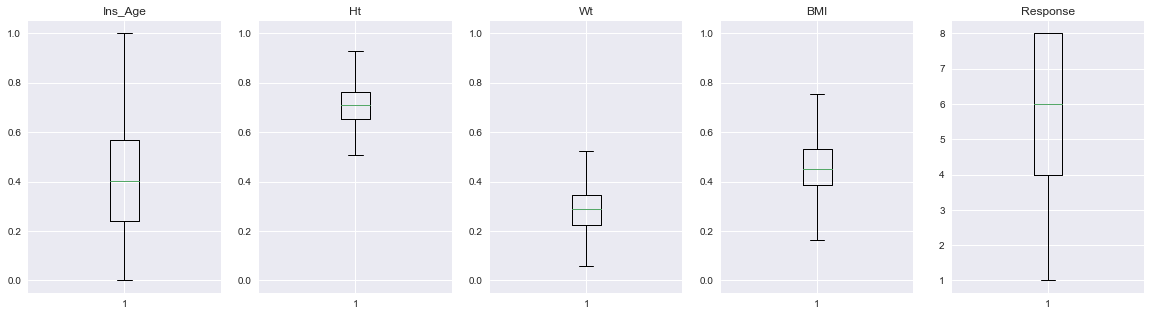

In [6]:
plt.figure(figsize=(20, 5))
for i, col in enumerate(exp_data.columns):
    plt.subplot(1, 5, i + 1)
    plt.boxplot(data_raw[col].values)
    plt.title(col)

# data_raw['Response'].hist().plot()
plt.show()

The "Response" boxplot above shows that higher value is majority.

### 2.2.2. histogram

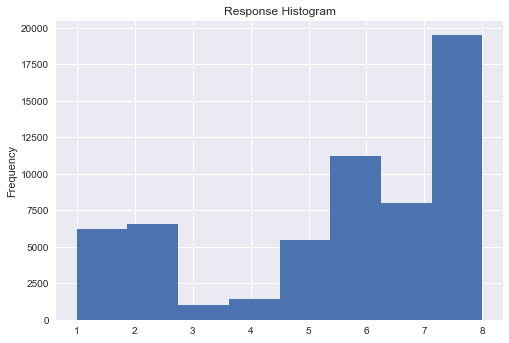

In [7]:
data_raw['Response'].plot(kind='hist', bins=8, title='Response Histogram')
plt.show()

The "Response" histogram shows "Response" 8 is majority and "Response" 3 and 4 are minority

### 2.2.3. scatter maxrix and heatmap

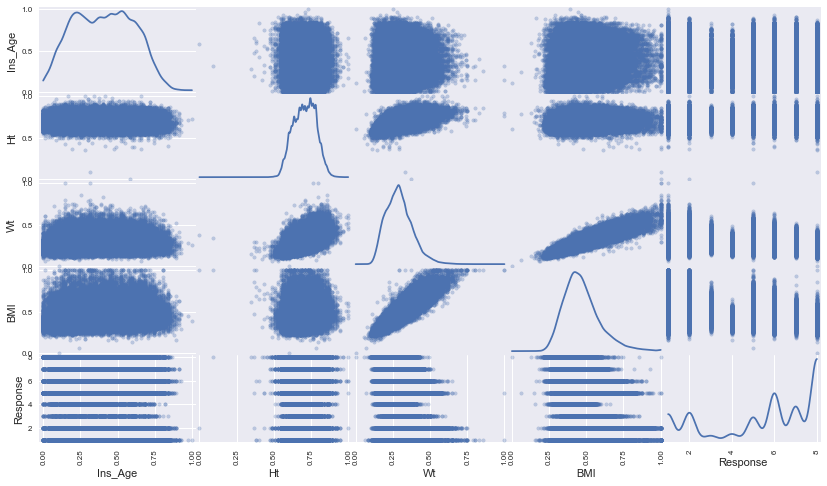

In [8]:
pd.scatter_matrix(exp_data, alpha=0.3, figsize=(14, 8), diagonal='kde')
plt.show()

The scatter matrix above shows "Wt" and "BMI" has strong correlation. and "Wt" and "Ht" has weak correlation.

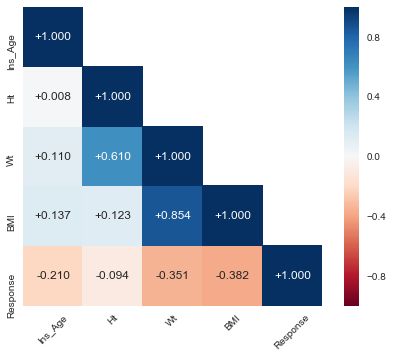

In [9]:
# calculate correlation
corr = exp_data.corr()

# ready for heatmap
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True
# show heatmap
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, square=True, annot=True,
                     cmap='RdBu', fmt='+.3f')
    plt.xticks(rotation=45, ha='center')
plt.show()

The heatmap above shows the correlation between "Response" and "BMI" is -0.382, weak negative correlation. This shows that the lower response value becomes, the higher BMI value becomes. In other words, I think that "Response" 1 is the highest risk value and "Response" 8 is the lowest risk value.


## 2.3. Algorithms and Techniques

## 2.4. Benchmark

In this Kaggle project, benchmark is not provided.
I'm going to choose [Decision Trees](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) and [Stochastic Gradient Descent](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) as the benchmark models.

Decision Trees is one of the basic classification model and can accept continuous number, discrete number, and categorized data.
Therefore, I think Decision Trees is suitable.
The benchmark model uses all features in train dataset.
All decision trees's parameters, such as max depth, are set to default.

Stochastic Gradient Descent is a simple linear classifier.
This classifier can show how a final solution needs to introduce non-linearity to produce a good result.

* reference
  * https://review.udacity.com/#!/reviews/1094124


### 2.4.1 create dataset for benchmark

To create benchmark, I'm going to make preprocess for training  and testing.
1. make categorical features onehot encoded. 
2. fill blank fields with 0.
3. drop target column(Response).
4. split dataset into train data and test data.

In [10]:
ONEHOT_ENCODING_COLS = ['Product_Info_1', 'Product_Info_2', 'Product_Info_3', 'Product_Info_5', 'Product_Info_6', 'Product_Info_7', 'Employment_Info_2', 'Employment_Info_3', 'Employment_Info_5', 'InsuredInfo_1', 'InsuredInfo_2', 'InsuredInfo_3', 'InsuredInfo_4', 'InsuredInfo_5', 'InsuredInfo_6', 'InsuredInfo_7', 'Insurance_History_1', 'Insurance_History_2', 'Insurance_History_3', 'Insurance_History_4', 'Insurance_History_7', 'Insurance_History_8', 'Insurance_History_9', 'Family_Hist_1', 'Medical_History_2', 'Medical_History_3', 'Medical_History_4', 'Medical_History_5', 'Medical_History_6', 'Medical_History_7', 'Medical_History_8', 'Medical_History_9', 'Medical_History_11', 'Medical_History_12', 'Medical_History_13', 'Medical_History_14', 'Medical_History_16', 'Medical_History_17', 'Medical_History_18', 'Medical_History_19', 'Medical_History_20', 'Medical_History_21', 'Medical_History_22', 'Medical_History_23', 'Medical_History_25', 'Medical_History_26', 'Medical_History_27', 'Medical_History_28', 'Medical_History_29', 'Medical_History_30', 'Medical_History_31', 'Medical_History_33', 'Medical_History_34', 'Medical_History_35', 'Medical_History_36', 'Medical_History_37', 'Medical_History_38', 'Medical_History_39', 'Medical_History_40', 'Medical_History_41',]
STRING_COLS = ['Product_Info_2',]
NUMERIC_COLS = list(set(data_raw.columns) - set(ONEHOT_ENCODING_COLS) - {'Response'})
data = data_raw.copy()
# 1. one-hot encoding
data = pd.get_dummies(data, columns=ONEHOT_ENCODING_COLS)
# 2. fill blank fields with 0.
data = data.fillna(0)

# extract Response column
target_columns = ['Response',]
targets = data[target_columns]
# 3. drop Response column from X features
features_raw = data.drop('Response', axis = 1)

# 4. split dataset into train and test.
X_train, X_test, Y_train, Y_test = train_test_split(features_raw, targets, test_size=0.1, random_state=RANDOM_STATE)
print("X train num = {}".format(X_train.shape[0]))
print("Y train num = {}".format(Y_train.shape[0]))
print("X test num = {}".format(X_test.shape[0]))
print("Y test num = {}".format(Y_test.shape[0]))

X train num = 53442
Y train num = 53442
X test num = 5939
Y test num = 5939


Then, caliculate benchmark result for each models.

In [11]:
reg = DecisionTreeClassifier(random_state=RANDOM_STATE)
reg.fit (X_train, Y_train['Response'])
predictions = reg.predict(X_test)
value = cohen_kappa_score(Y_test['Response'], predictions, weights='quadratic')
print("DecisionTreeClassifier kappa = {}".format(value))

DecisionTreeClassifier kappa = 0.3869483523274083


In [12]:
reg = SGDClassifier(max_iter=1000, tol=1e-3, random_state=RANDOM_STATE)
reg.fit (X_train, Y_train['Response'])
predictions = reg.predict(X_test)
value = cohen_kappa_score(Y_test['Response'], predictions, weights='quadratic')
print("SGDClassifier kappa = {}".format(value))

SGDClassifier kappa = 0.4068430816709081


The benchmark results are shown below.  
SGD is relatively better than Decision Tree.  
I think this is because Decision Tree model is overfitted more strongly.

|model|DecisionTreeClassifier|SGDClassifier|
|--|--|--|
|Quadratic Weighted Kappa (score)|0.38694|0.40684|

# 3. Methodology

## 3.1. Data Preprocessing

### 3.1.1. Data Splitting
My approach contains preprocess evaluation.  
Therefore, the dataset is split into 3 parts, train, validate, and test.  
If I split 2 parts, train and test, model selection have to be evaluated by test dataset which is used in preprocess evaluation.  
And this should cause overfitting. 
The ratio of the number is 80%, 10%, 10% each.  
The train dataset is used for training model and model tuning.  
The validate dataset is used for evaluating preprocess, evaluating model selection.  
The test dataset is used for evaluating benchmark model and final model.


In [13]:
def split_dataset(features, targets, random_state=RANDOM_STATE, target_column='Response'):
    # split dataset into train, validate, and test dataset
    # train dataset: 80%
    # validate dataset: 10%
    # test dataset: 10%

    X_train, x, Y_train, y = train_test_split(features, targets, test_size=0.2, random_state=42)
    X_validate, X_test, Y_validate, Y_test = train_test_split(x, y, test_size=0.5, random_state=42)
    return X_train, X_validate, X_test, Y_train, Y_validate, Y_test

### 3.1.2. Imputation

As described at Data Exploration, several fields have blank fields.
To fill blank field with default value, I'm going to use [Imputation](http://scikit-learn.org/stable/modules/preprocessing.html#imputation).  
Domain knowledge can not be applied to these fields, I'm going to compare to decide which default value is the best.

* reference
  * http://scikit-learn.org/stable/modules/preprocessing.html#imputation-of-missing-values

In [14]:
# for numeric
def fillin_numeric_nandata(data, strategy):
    # fillin blank fields with 'strategy' data
    imp_num = Imputer(missing_values="NaN", strategy=strategy, axis=0)
    data[NUMERIC_COLS] = imp_num.fit_transform(data[NUMERIC_COLS].values)
    return data


NEVER_APPEARED_CATEGORICAL_VALUE = -1

# check NEVER_APPEARED_CATEGORICAL_VALUE is not appeared in any categorical columns
for column in ONEHOT_ENCODING_COLS:
    values = list(data_raw[column].value_counts().keys())
    assert NEVER_APPEARED_CATEGORICAL_VALUE not in values

# for categorical
def fillin_categorical_nandata(data, strategy, value=NEVER_APPEARED_CATEGORICAL_VALUE):
    # When strategy is most frequent, the fillin value is the most fequent value.
    # When strategy is the others, the fillin value is never appeared value.
    if strategy == 'most_frequent':
        # https://github.com/scikit-learn-contrib/sklearn-pandas#categoricalimputer
        # fillin blank fields into most_frequent data
        imp_str = CategoricalImputer(missing_values="NaN", copy=True)
        data[STRING_COLS] = imp_str.fit_transform(data[STRING_COLS].values)

        # fillin blank fields with 'strategy' data
        categorical_columns = list(set(ONEHOT_ENCODING_COLS) - set(STRING_COLS))
        imp_num = Imputer(missing_values="NaN", strategy=strategy, axis=0)
        data[categorical_columns] = imp_num.fit_transform(data[categorical_columns].values)
    else:
        data[ONEHOT_ENCODING_COLS] = data[ONEHOT_ENCODING_COLS].fillna(value)
    return data

I tried to fill blank fields with values generated by some strategies.  
The candidate algorithm for numerical field is mean, median, and most frequent value [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html).  
The candidate algorithm for categorical field is -1(never appeared in dataset), and most frequent value.  

Next, I'm going to compare each Imputer strategy by checking all pairs' metrics.  
Random Forest is used for training.  
This is because Random Forest is used in feature selection.

In [15]:
numeric_strategies = ['mean', 'median', 'most_frequent']
categorical_strategies = ['most_frequent', 'fillunknown']
results = []
for numeric_strategy, categorical_strategy in itertools.product(numeric_strategies, categorical_strategies):
    data = data_raw.copy()
    # data = pd.get_dummies(data, columns=ONE_HOT_ENCODE_COLS)
    # corr = data.corr()
    
    # res_corr = corr.loc[(corr['Response'] > THRESHOLD) | (corr['Response'] < -THRESHOLD)]
    # correlated_columns = pd.DataFrame(res_corr['Response']).index.values.tolist()

    target_columns = ['Response',]
    targets = data[target_columns]
    features_raw = data.drop('Response', axis = 1)
    
    # fillin blank fields with 'strategy' data
    features_raw = fillin_numeric_nandata(features_raw, numeric_strategy)
    if categorical_strategy == 'most_frequent':
        features_raw = fillin_categorical_nandata(features_raw, categorical_strategy)
    else:
        features_raw = fillin_categorical_nandata(features_raw, categorical_strategy, -1)

    # do onehot encoding
    features_raw = pd.get_dummies(features_raw, columns=ONEHOT_ENCODING_COLS)

    # split dataset into train, validate and test
    X_train, X_validate, X_test, Y_train, Y_validate, Y_test = split_dataset(features_raw, targets)

    reg = RandomForestClassifier(random_state=RANDOM_STATE)
    reg.fit (X_train, Y_train['Response'])
    predictions = reg.predict(X_validate)
    value = cohen_kappa_score(Y_validate['Response'], predictions, weights='quadratic')
    results.append(value)
print(results)

[0.4713598503935349, 0.4713598503935349, 0.47017914841279851, 0.47017914841279851, 0.48494483157241719, 0.48494483157241719]


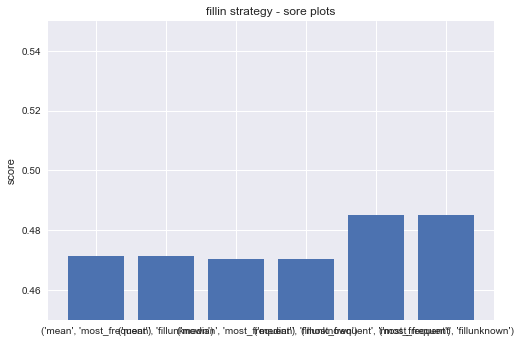

[('mean', 'most_frequent'),
 ('mean', 'fillunknown'),
 ('median', 'most_frequent'),
 ('median', 'fillunknown'),
 ('most_frequent', 'most_frequent'),
 ('most_frequent', 'fillunknown')]

In [16]:
# plot each result
plt.bar(range(len(results)), results, align='center')
plt.xticks(range(len(results)),
           list(itertools.product(numeric_strategies, categorical_strategies)))
plt.ylabel('score')
plt.title('fillin strategy - sore plots')
plt.ylim(0.45, 0.55)
plt.show()
list(itertools.product(numeric_strategies, categorical_strategies))

The figure above shows that for numerical data, most frequent strategy is the best.  
And for categorical data, the results are same.  
Therefore I'm going to adapt most frequent for numerical and never shown value for categorical.

In [17]:
NUMERIC_STRATEGY = 'most_frequent'
CATEGORICAL_STRATEGY = 'unknown'

### 3.1.3. feature selection

The train dataset has more than 100 features.  
Some features might not be correlated to "Response" and should be dropped for escaping from overfitting.  
To discard irrelevant features, I'm going to use correlation or Tree-based feature selection.  

#### 3.1.3.1.  correlation

At first, I calculated each features correlation with "Response" and sorted by the value.


In [18]:
data_root = data_raw.copy()
# fillin blank fields with mean data
data_root = fillin_numeric_nandata(data_root, NUMERIC_STRATEGY)
# fillin blank fields with never shown
data_root = fillin_categorical_nandata(data_root, CATEGORICAL_STRATEGY)

# do onehot encoding
data_root = pd.get_dummies(data_root, columns=ONEHOT_ENCODING_COLS)

# compute correlations
corr = data_root.corr()

Then, increased number of the stronger correlated features by 10 and calculated the score.  

In [19]:
# https://stackoverflow.com/questions/41340023/pandas-sort-column-by-correlation-to-first-column

# sort columns by correlation
columns = list(corr.columns.values)
ix = corr.abs().sort_values('Response', ascending=False).index
correlate_sorted_columns = list(ix)
correlate_sorted_columns.remove('Response')
print("the best 3 correlated columns and their values")
print(corr['Response'][correlate_sorted_columns[1:4]])

the best 3 correlated columns and their values
Wt                     -0.351395
Medical_History_23_1   -0.286595
Medical_History_23_3    0.286566
Name: Response, dtype: float64


In [20]:
correlated_results = []

target_columns = ['Response',]
targets = data_root[target_columns]
features = data_root.drop('Response', axis = 1)

for num in range(1, len(correlate_sorted_columns) // 10):
    # select correlated features
    correlated_columns = correlate_sorted_columns[:num*10]
    selected_features = features[correlated_columns]

    # split dataset into train, validate and test
    X_train, X_validate, X_test, Y_train, Y_validate, Y_test = split_dataset(selected_features, targets)

    # train model
    reg = RandomForestClassifier(random_state=RANDOM_STATE)
    reg.fit (X_train, Y_train['Response'])
    # evaluate with validate dataset
    predictions = reg.predict(X_validate)
    value = cohen_kappa_score(Y_validate['Response'], predictions, weights='quadratic')
    correlated_results.append(value)
    # print("Xtrain={} Ytrain={} Xtest={} Ytest={} result={}".format(
    #        X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, value))


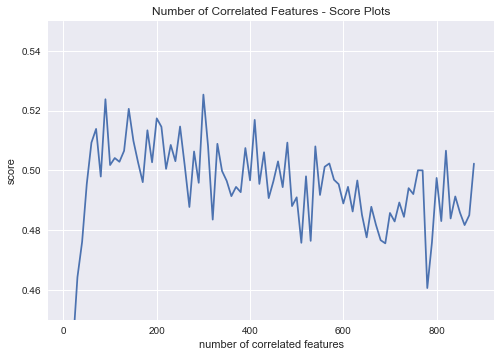

In [21]:
plt.plot([i * 10 for i in range(1, len(correlate_sorted_columns) // 10)], correlated_results)
plt.xlabel('number of correlated features')
plt.ylabel('score')
plt.title('Number of Correlated Features - Score Plots')
plt.ylim(0.45, 0.55)
plt.show()

The figure above shows score transition with number of ordered correlated features.  
This graph shows that the score transition is very volatile and seems not to be robust for dataset variation.  
Next, I'm going to calculate mean and standard deviation around peek.

In [22]:
ranged_correlated_results = []

target_columns = ['Response',]
targets = data_root[target_columns]
features = data_root.drop('Response', axis = 1)

for num in range(100, 200):
    # select correlated features
    correlated_columns = correlate_sorted_columns[:num]
    selected_features = features[correlated_columns]

    # split dataset into train, validate and test
    X_train, X_validate, X_test, Y_train, Y_validate, Y_test = split_dataset(selected_features, targets)

    # train model
    reg = RandomForestClassifier(random_state=RANDOM_STATE)
    reg.fit (X_train, Y_train['Response'])
    # evaluate with validate dataset
    predictions = reg.predict(X_validate)
    value = cohen_kappa_score(Y_validate['Response'], predictions, weights='quadratic')
    ranged_correlated_results.append(value)
    # print("Xtrain={} Ytrain={} Xtest={} Ytest={} result={}".format(
    #        X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, value))


In [23]:
sorted_results_indices = np.argsort(ranged_correlated_results)[::-1]
best_index = sorted_results_indices[0]
best_feature_num = best_index + 100
print("the best number of correlated feature={} metrics={}".format(best_feature_num, ranged_correlated_results[best_index]))
ranged_correlated_results = np.array(ranged_correlated_results)
print("mean={} var={} std={}".format(ranged_correlated_results.mean(),
                                     ranged_correlated_results.var(),
                                     ranged_correlated_results.std()))
correlated_columns = correlate_sorted_columns[:best_feature_num]

the best number of correlated feature=123 metrics=0.54451146425161
mean=0.5134673226952906 var=8.314525707348162e-05 std=0.009118402111854995


#### 3.1.3.2. feature imoprtance

Next, I created a figure that shows the score transition with number of strong Gini features importance by similar procedure as correlation.  

In [24]:
data_root = data_raw.copy()
# fillin blank fields with mean data
filled_data = fillin_numeric_nandata(data_root, NUMERIC_STRATEGY)
# fillin blank fields with never shown
filled_data = fillin_categorical_nandata(filled_data, CATEGORICAL_STRATEGY)

# do onehot encoding
data_root = pd.get_dummies(filled_data, columns=ONEHOT_ENCODING_COLS)

# split dataset
target_columns = ['Response',]
targets = data_root[target_columns]
features = data_root.drop('Response', axis = 1)
X_train, X_validate, X_test, Y_train, Y_validate, Y_test = split_dataset(features, targets)

base_cls = RandomForestClassifier(random_state=RANDOM_STATE)
base_cls.fit (X_train, Y_train['Response'])
#predictions = base_cls.predict(X_validate)
#value = cohen_kappa_score(Y_validate['Response'], predictions, weights='quadratic')
#print("RandomForestClassifier kappa = {}".format(value))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [25]:
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
# sort columns by importances
importances = base_cls.feature_importances_
indices = np.argsort(importances)[::-1]
columns = list(features.columns.values)
important_sorted_columns = []
for idx in indices:
    important_sorted_columns.append(columns[idx])

gini_importance_results = []
for num in range(1, len(important_sorted_columns) // 10):
    # select important features
    important_columns = important_sorted_columns[:num*10]
    selected_features = features[important_columns]
    # split dataset into train, validate and test
    X_train, X_validate, X_test, Y_train, Y_validate, Y_test = split_dataset(selected_features, targets)

    # train model
    reg = RandomForestClassifier(random_state=RANDOM_STATE)
    reg.fit (X_train, Y_train['Response'])
    # evaluate with validate dataset
    predictions = reg.predict(X_validate)
    value = cohen_kappa_score(Y_validate['Response'], predictions, weights='quadratic')
    gini_importance_results.append(value)

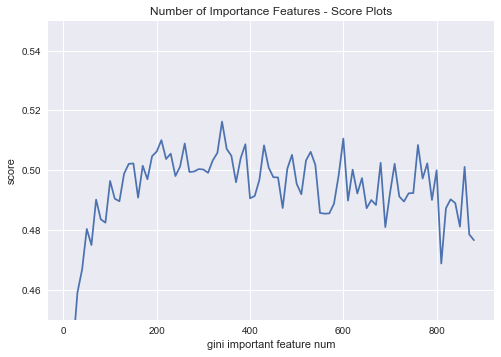

In [26]:
plt.plot([i * 10 for i in range(1, len(important_sorted_columns) // 10)], gini_importance_results)
plt.xlabel('gini important feature num')
plt.ylabel('score')
plt.title('Number of Importance Features - Score Plots')
plt.ylim(0.45, 0.55)
plt.show()

This graph above shows that the score transition is less volatile than correlation.  
Next, I calculate several range scores around the peaks for correlation and Gini importance.  

In [27]:
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
# sort columns by importances
importances = base_cls.feature_importances_
indices = np.argsort(importances)[::-1]
columns = list(features.columns.values)
important_sorted_columns = []
for idx in indices:
    important_sorted_columns.append(columns[idx])

start = 200
end = 400
ranged_gini_importance_results = []
for num in range(start, end):
    important_columns = important_sorted_columns[:num]
    # select important features
    selected_features = features[important_columns]
    # split dataset into train, validate and test
    X_train, X_validate, X_test, Y_train, Y_validate, Y_test = split_dataset(selected_features, targets)
    # train model
    reg = RandomForestClassifier(random_state=RANDOM_STATE)
    reg.fit (X_train, Y_train['Response'])
    # evaluate with validate dataset
    predictions = reg.predict(X_validate)
    value = cohen_kappa_score(Y_validate['Response'], predictions, weights='quadratic')
    ranged_gini_importance_results.append(value)
# print(results)


In [28]:
sorted_results_indices = np.argsort(ranged_gini_importance_results)[::-1]
best_index = sorted_results_indices[0]
best_feature_num = best_index + 200
print("the best number of important feature={} metrics={}".format(best_feature_num, ranged_gini_importance_results[best_index]))
ranged_gini_importance_results = np.array(ranged_gini_importance_results)
print("mean={} var={} std={}".format(ranged_gini_importance_results.mean(),
                                     ranged_gini_importance_results.var(),
                                     ranged_gini_importance_results.std()))
IMPORTANT_COLUMNS = important_sorted_columns[:best_feature_num]

the best number of important feature=222 metrics=0.5268310963503917
mean=0.5039208502161983 var=6.241686709984742e-05 std=0.007900434614617566


||correlation|gini importance|
|--|---|--|
|score|0.513|0.504|
|std|0.00912|0.00790|

The table above shows that the Gini feature importance's standard deviation is less than correlation's and the mean value is not so different.  
I think this is because in this project we want to drop unrelated features for escaping from overfitting.
Correlation directly describes the dependency with "Response".
Therefore, I think the score more easily tends to be changed by dataset.  
On the other hand, the tree split become smaller, the larger Gini importance becomes.  
Gini importance does not directly relate with dependency with "Response".  
As the result above, I think Gini Importance is prefer.

* references
  * http://scikit-learn.org/stable/modules/feature_selection.html
  * https://medium.com/@ceshine/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3

#### 3.1.3.3. outlier
Next, I'm going to check dropping outliers effect with Turkey Method.  

* references
  * http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/


In [29]:
data_root = data_raw.copy()
# fillin blank fields with mean data
filled_data = fillin_numeric_nandata(data_root, NUMERIC_STRATEGY)
# fillin blank fields with never shown
filled_data = fillin_categorical_nandata(filled_data, CATEGORICAL_STRATEGY)

# do onehot encoding
data_root = pd.get_dummies(filled_data, columns=ONEHOT_ENCODING_COLS)

outliers_id_sets = []
outlier_set = set()
# For each feature find the data points with extreme high or low values
for numeric_feature in NUMERIC_COLS:
    # if numeric_feature not in correlated_columns:
    if numeric_feature not in ['Wt', 'Ht', 'BMI']:
        continue

    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(data_root[numeric_feature], 25)

    # Calculate Q1 (25th percentile of the data) for the given feature
    Q2 = np.percentile(data_root[numeric_feature], 50)

    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(data_root[numeric_feature], 75)

    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5 * (Q3 - Q1)

    # skip unchanged features
    if (Q1 - step) == Q2 or Q2 == (Q3 + step):
        continue

    # extract outliers
    outliers = data_root[~((data_root[numeric_feature] >= Q1 - step) & (data_root[numeric_feature] <= Q3 + step))]
    # extract outliers row ids
    outliers_id_sets.append(set(outliers.index.values))
    # Display the outliers
    print("Data points considered outliers for the feature '{}':{}".format(
        numeric_feature, len(outliers)))
    #display(outliers)
    outlier_set |= set(outliers.index.values)
    
print("number of all outliers = {}".format(len(outlier_set)))

# Remove the outliers, if any were specified
good_data = data_root.drop(data_root.index[list(outlier_set)]).reset_index(drop=True)

print("")
print("Outliers Data Samples")
display(data_root.ix[list(outlier_set)][['Ht', 'Wt', 'BMI', 'Response']].head(5))
print("")

# split dataset into train, validate and test
target_columns = ['Response',]
targets = good_data[target_columns]
good_features = good_data[correlated_columns]
X_train, X_validate, X_test, Y_train, Y_validate, Y_test = split_dataset(good_features, targets)

cls = RandomForestClassifier(random_state=RANDOM_STATE)
cls.fit (X_train, Y_train['Response'])
predictions = cls.predict(X_validate)
value = cohen_kappa_score(Y_validate['Response'], predictions, weights='quadratic')
print("score excluded with outliers = {}".format(value))

Data points considered outliers for the feature 'Ht':72
Data points considered outliers for the feature 'BMI':1634
Data points considered outliers for the feature 'Wt':854
number of all outliers = 1915

Outliers Data Samples


Ht        Wt       BMI  Response
4098   0.727273  0.476987  0.760661         2
40963  0.672727  0.497908  0.886401         2
49156  0.618182  0.453975  0.902625         2
24582  0.618182  0.428870  0.852394         2
36875  0.836364  0.633891  0.837459         2


score excluded with outliers = 0.4832962975860985


The metrics score became 0.483, which is worse than full dataset.  
It seems to be because each column's standard deviation is large and filtering outlier drops important rows.  
Therefore, I'm not going to address outliers.  


# 4. Result
## 4.1. Model Evaluation and Validation
### 4.1.1.  model selection


The final model candidates are mainly ensemble methods,
[RandamForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html),
[ExtraTrees](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html), and
[GradientBoosting](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html).  
This is because I think this dataset has many features and main problem is how to reduce overfitting,
and ensemble methods are suitable.
These models are compared with default parameters except for number of estimators.

* references
  * http://scikit-learn.org/stable/modules/ensemble.html
  
### 4.1.1.1. prepare dataset

In [30]:
data_root = data_raw.copy()
# fillin blank fields with mean data
filled_data = fillin_numeric_nandata(data_root, NUMERIC_STRATEGY)
# fillin blank fields with never shown
filled_data = fillin_categorical_nandata(filled_data, CATEGORICAL_STRATEGY)

# do onehot encoding
data_root = pd.get_dummies(filled_data, columns=ONEHOT_ENCODING_COLS)

# split dataset
target_columns = ['Response',]
targets = data_root[target_columns]
features = data_root.drop('Response', axis = 1)
features = features[IMPORTANT_COLUMNS]
X_train, X_validate, X_test, Y_train, Y_validate, Y_test = split_dataset(features, targets)

#### 4.1.1.2. prepare scorer

In [31]:
# create scorer with quadratic weights
cohen_kappa_scoring = make_scorer(cohen_kappa_score, weights='quadratic')

#### 4.1.1.3. define train and model function for basic and ensemble classifier

The each model is evaluated with default parameter except for number of estimators.  
In general, the bigger number of estimators, the better the score become to some extent.  
And each model's default number of estimators are different.  
Therefore, the number of estimators is set to the same value, 100.

In [32]:
def train_and_test_plain_model(klass, name, X_train, Y_train, X_test, Y_test):
    cls = klass(random_state=RANDOM_STATE)
    cls.fit (X_train, Y_train['Response'])
    predictions = cls.predict(X_test)
    value = cohen_kappa_score(Y_test['Response'], predictions, weights='quadratic')
    print("{} test result = {}".format(name, value))
    
def train_and_test_plain_ensemble_model(klass, name, X_train, Y_train, X_test, Y_test, n_estimators=100):
    cls = klass(random_state=RANDOM_STATE, n_estimators=n_estimators)
    cls.fit (X_train, Y_train['Response'])
    predictions = cls.predict(X_test)
    value = cohen_kappa_score(Y_test['Response'], predictions, weights='quadratic')
    print("{} test result = {}".format(name, value))

#### 4.1.1.4.1. compare models: simple comparison

In [33]:
train_and_test_plain_model(DecisionTreeClassifier, 'Decision Tree', X_train, Y_train, X_test, Y_test)
train_and_test_plain_model(SGDClassifier, 'SGD', X_train, Y_train, X_test, Y_test)
train_and_test_plain_ensemble_model(RandomForestClassifier, 'Random Forest', X_train, Y_train, X_test, Y_test)
train_and_test_plain_ensemble_model(ExtraTreesClassifier, 'Extra Trees', X_train, Y_train, X_test, Y_test)
train_and_test_plain_ensemble_model(AdaBoostClassifier, 'Ada Boost', X_train, Y_train, X_test, Y_test)
train_and_test_plain_ensemble_model(GradientBoostingClassifier, 'Gradient Boosting', X_train, Y_train, X_test, Y_test)

Decision Tree test result = 0.4114187979031825


/home/sthin/anaconda3/envs/aind/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGD test result = 0.22015065702190895
Random Forest test result = 0.5368331454447641
Extra Trees test result = 0.5287009102465521
Ada Boost test result = 0.4941944099301131
Gradient Boosting test result = 0.5428599743014714


* abount Ada Boost
  * Ada Boost is easy to overfitting if the model is complex(many features).  
  * Therefore, in this project, Ada Boost seems not to be suitable.
* references 
  * http://math.mit.edu/~rothvoss/18.304.3PM/Presentations/1-Eric-Boosting304FinalRpdf.pdf

#### 4.1.1.4.2. compare models: check vulnerability


Random Forest: avg=0.5190413283644916 std=0.004811416337527098


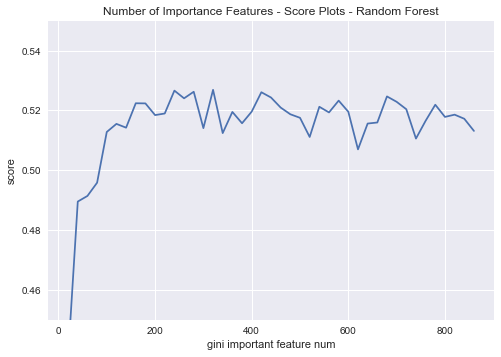

Extra Trees: avg=0.5067483281170674 std=0.010868169816282488


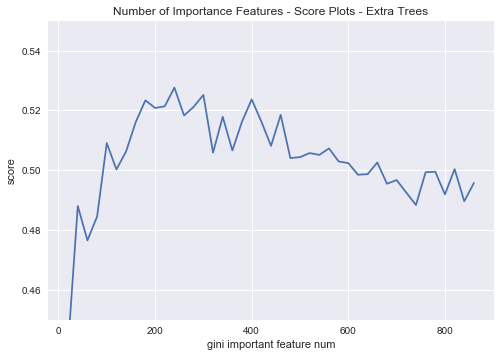

Gradient Boosting: avg=0.5245112325286803 std=0.002110610148130211


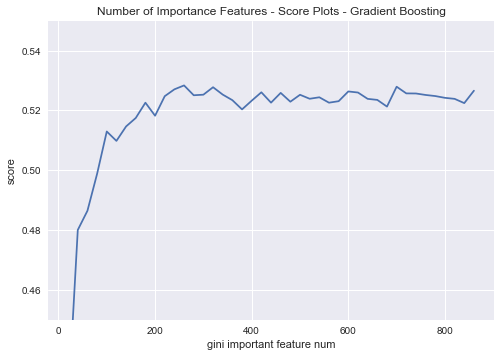

In [34]:
# devide features into "Response" and the other feture
target_columns = ['Response',]
targets = data_root[target_columns]
features = data_root.drop('Response', axis = 1)

def train_and_plot_feature_importance(classifier, name, steps=20, n_estimators=100, n_jobs=4):
    results = np.array([])
    for num in range(1, len(important_sorted_columns) // steps):
        # select important features
        important_columns = important_sorted_columns[:num*steps]
        selected_features = features[important_columns]
        # split dataset into train, validate and test
        X_train, X_validate, X_test, Y_train, Y_validate, Y_test = split_dataset(selected_features, targets)

        # train model
        reg = classifier(random_state=RANDOM_STATE, n_estimators=n_estimators, n_jobs=n_jobs)
        reg.fit (X_train, Y_train['Response'])
        # evaluate with validate dataset
        predictions = reg.predict(X_validate)
        value = cohen_kappa_score(Y_validate['Response'], predictions, weights='quadratic')
        results = np.append(results, value)
    print("{}: avg={} std={}".format(name, results[9:].mean(), results[9:].std()))
    plt.plot([i * steps for i in range(1, len(important_sorted_columns) // steps)], results)
    plt.xlabel('gini important feature num')
    plt.ylabel('score')
    plt.title('Number of Importance Features - Score Plots - ' + name)
    plt.ylim(0.45, 0.55)
    plt.show()

train_and_plot_feature_importance(RandomForestClassifier, 'Random Forest')
train_and_plot_feature_importance(ExtraTreesClassifier, 'Extra Trees')
train_and_plot_feature_importance(GradientBoostingClassifier, 'Gradient Boosting')

The results above shows that [Gradient Boosting](http://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting) has the best score and the least vulnerable for number of features.  
Therefore, I choose Gradient Boosting as the final training model.  
According to scikit-learn document above, Gradient Boosting has advantage of robustness to outliers.  
In my preprocess, I do not drop outliers.  
Therefore, Gradient Boosting might effectively work for my dataset.

* references
  * https://en.wikipedia.org/wiki/Gradient_boosting

#### 4.1.2. Model Tuning

At the final step, Gradient Boosting parameters are tuned to create a final model.  
Tuning parameters are 'min_samples_leaf', 'max_depth', 'max_features', and 'learning_rate'.  
These parameters were selected by referring to GradientBoosting document.  

Ideally, training with wide range parameter's values and all parameter's combinations is preferred.  
However, Gradient Boosting training takes a lot of time.  
And, it is difficult to train all parameters at once by training with many patterns and all combinations.  

Therefore, I trained model for each one parameter at once with a few values.  
During checking one parameter, the other parameters are fixed. 

* reference
  * http://blog.datarobot.com/gradient-boosted-regression-trees

#### 4.1.2.1. define grid search training function

In [35]:
def fit_grid_search(classifier, param_grid, pkl_filename,
                    X_train, Y_train,
                    scoring=cohen_kappa_scoring, n_jobs=4, verbose=True,
                    cv=5, refit=True):
    # create grid search model
    grid_obj = GridSearchCV(classifier(),
                            param_grid,
                            n_jobs=n_jobs,
                            verbose=verbose,
                            scoring=scoring,
                            cv=cv,
                            refit=refit)
    # train model
    grid_fit = grid_obj.fit(X_train, Y_train['Response'])
    print("estimater:" + str(grid_fit.best_estimator_))
    print("best params:" + str(grid_fit.best_params_))
    print("best score:" + str(grid_fit.best_score_))
    print("scores=" + str(grid_fit.cv_results_['mean_test_score']))

    # Dump the trained classifier with Pickle
    with open(pkl_filename, 'wb') as model_pkl:
        pickle.dump(grid_fit, model_pkl)
    return grid_fit

#### 4.1.2.2. create dataset

In [36]:
data_root = data_raw.copy()
# fillin blank fields with mean data
filled_data = fillin_numeric_nandata(data_root, NUMERIC_STRATEGY)
# fillin blank fields with never shown
filled_data = fillin_categorical_nandata(filled_data, CATEGORICAL_STRATEGY)

# do onehot encoding
data_root = pd.get_dummies(filled_data, columns=ONEHOT_ENCODING_COLS)

# split dataset
target_columns = ['Response',]
targets = data_root[target_columns]
features = data_root.drop('Response', axis = 1)
features = features[IMPORTANT_COLUMNS]

X_train, X_validate, X_test, Y_train, Y_validate, Y_test = split_dataset(features, targets)
# append train dataset and validate dataset because data splitting is executed in grid search.
X_train = X_train.append(X_validate)
Y_train = Y_train.append(Y_validate)
X_validate = None
Y_validate = None

#### 4.1.2.3. check min_samples_leaf

In [37]:
# tuning grandient boosting params
param_grid = {
    'min_samples_leaf': [1, 5, 10],
    'random_state': [RANDOM_STATE],
}
grid_fit = fit_grid_search(GradientBoostingClassifier, param_grid,
                           'gradient_boosting_params.pkl',
                           X_train, Y_train)

# check test dataset score
predictions = grid_fit.predict(X_test)
value = cohen_kappa_score(Y_test, predictions, weights='quadratic')
print("gradient boosting test result = " + str(value))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed: 14.5min finished


estimater:GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)
best params:{'min_samples_leaf': 10, 'random_state': 42}
best score:0.538858456095
scores=[ 0.5375278   0.53857896  0.53885846]
gradient boosting test result = 0.545492736356


#### 4.1.2.4. check max_depth

In [38]:
# tuning grandient boosting params
param_grid = {
    'min_samples_leaf': [10,],
    'max_depth': [1, 3, 5, 10],
    'random_state': [RANDOM_STATE],
}
grid_fit = fit_grid_search(GradientBoostingClassifier, param_grid,
                           'gradient_boosting_params.pkl',
                           X_train, Y_train)

# check test dataset score
predictions = grid_fit.predict(X_test)
value = cohen_kappa_score(Y_test, predictions, weights='quadratic')
print("gradient boosting test result = " + str(value))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed: 82.6min finished


estimater:GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)
best params:{'max_depth': 5, 'min_samples_leaf': 10, 'random_state': 42}
best score:0.557894372343
scores=[ 0.48054802  0.53885846  0.55789437  0.5551381 ]
gradient boosting test result = 0.565118680103


#### 4.1.2.4. check max_features

In [39]:
# tuning grandient boosting params
param_grid = {
    'min_samples_leaf': [10,],
    'max_depth': [5],
    'max_features': ['sqrt', 'log2', None],
    'random_state': [RANDOM_STATE],
}
grid_fit = fit_grid_search(GradientBoostingClassifier, param_grid,
                           'gradient_boosting_params.pkl',
                           X_train, Y_train)

# check test dataset score
predictions = grid_fit.predict(X_test)
value = cohen_kappa_score(Y_test, predictions, weights='quadratic')
print("gradient boosting test result = " + str(value))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed: 18.1min finished


estimater:GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)
best params:{'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'random_state': 42}
best score:0.557894372343
scores=[ 0.55490017  0.54874579  0.55789437]
gradient boosting test result = 0.565118680103


#### 4.1.2.5. check learning_rate

In [40]:
# tuning grandient boosting params
param_grid = {
    'min_samples_leaf': [10,],
    'max_depth': [5],
    'max_features': [None,],
    'learning_rate': [0.1, 0.5, 1.0],
    'random_state': [RANDOM_STATE],
}
grid_fit = fit_grid_search(GradientBoostingClassifier, param_grid,
                           'gradient_boosting_params.pkl',
                           X_train, Y_train)

# check test dataset score
predictions = grid_fit.predict(X_test)
value = cohen_kappa_score(Y_test, predictions, weights='quadratic')
print("gradient boosting test result = " + str(value))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed: 30.0min finished


estimater:GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)
best params:{'learning_rate': 0.1, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'random_state': 42}
best score:0.557894372343
scores=[ 0.55789437  0.54737964  0.49380337]
gradient boosting test result = 0.565118680103


#### 4.1.2.6. results

The table below are the results.

| min_samples_leaf|1 | 5 | 10|
|------|--|--|--|
| score|0.538|0.5386|0.5389|

|max_depth|1 | 3 | 5 | 10|
|--|--|--|--|--|
|score|0.481| 0.539 | 0.559 | 0.556|

|max_features | sqrt | log2 | all|
|--|--|--|--|
|score| 0.555 | 0.549 | 0.558|

|learning_rate| 0.1| 0.5 | 1.0|
|--|--|--|--|
|score|0.558 | 0.547 | 0.494|


### 4.1.3. final model validation

### 4.1.3.1. check overfitting

In [41]:
final_model = grid_fit

# check test dataset score
predictions = final_model.predict(X_test)
value = cohen_kappa_score(Y_test, predictions, weights='quadratic')
print("gradient boosting test result = " + str(value))

gradient boosting test result = 0.565118680103


As the result above described, the final model's max score for the train dataset is 0.557.  
And the final model's test dataset's score is 0.565.  
The test dataset has not been not used so far to create model. \newline
This shows the final model is not overfitting.


### 4.1.3.2. check robustness

I'm going to calculate test scores at 5 times by changing splitting's random state.  
This can check my model's score does not depend on specific dataset.  

In [42]:
import random

def train_and_test():
    random_state = random.choice(range(1, 10000))
    # split dataset into train, validate and test
    X_train_, X_validate_, X_test_, Y_train_, Y_validate_, Y_test_ = split_dataset(features_raw, targets, random_state=random_state)
    # append train dataset and validate dataset because data splitting is executed in grid search.
    X_train_ = X_train_.append(X_validate_)
    Y_train_ = Y_train_.append(Y_validate_)
    X_validate_ = None
    Y_validate_ = None

    # train model
    cls = GradientBoostingClassifier(
                min_samples_leaf=10,
                max_depth=5,
                max_features=None,
                learning_rate=0.1,
                random_state=random_state)
    cls.fit(X_train_, Y_train_['Response'])

    # check test dataset score
    predictions = cls.predict(X_test_)
    value = cohen_kappa_score(Y_test_['Response'], predictions, weights='quadratic')
    print("gradient boosting test result={} random_state={}".format(str(value), random_state))
    return value

# train and test at 5 times
results = []
for i in range(1, 6):
    results.append(train_and_test())
print("mean={}".format(np.mean(results)))
print("std={}".format(np.std(results)))

gradient boosting test result=0.56546186374 random_state=3744
gradient boosting test result=0.56546186374 random_state=8880
gradient boosting test result=0.56546186374 random_state=8087
gradient boosting test result=0.565502295858 random_state=3966
gradient boosting test result=0.56546186374 random_state=4584
mean=0.5654699501636611
std=1.6172847119078068e-05


As the result above, the mean score is 0.565, near the first model's result, and the standard deviation is low enough.  
Therefore, I think the final model has robustness in terms of dataset variation.


## 4.2. Justification

## 4.2.1. Compared with Benchmark

||Decision Tree|SGD|Final Model|
|--|--|--|--|
|score|0.387 | 0.407 | 0.562 |

From the table above, the final model became better than the benchmark models.

## 4.2.2. Compared with the competition winner

[The Kaggle competition result](https://www.kaggle.com/c/prudential-life-insurance-assessment/leaderboard)
shows the winner score is more than 0.67.  
My score is clearly lower than the winner.   
However, I think the final model's score is not so different from the winner's in terms of the usefulness for this project solution.   
I'm going to note about usefulness in the next visualization section.


# 5. Conclusion
## 5.1. Visualization

In [43]:
# check test dataset score
predictions = final_model.predict(X_test)
value = cohen_kappa_score(Y_test, predictions, weights='quadratic')
print("gradient boosting test result = " + str(value))
print("pred={}".format(list(predictions)[:20]))
print("true={}".format(list(Y_test['Response'])[:20]))

gradient boosting test result = 0.565118680103
pred=[6, 5, 8, 6, 8, 6, 6, 1, 6, 8, 8, 7, 6, 8, 6, 8, 6, 6, 5, 8]
true=[5, 5, 4, 7, 8, 6, 6, 1, 1, 8, 7, 7, 6, 8, 5, 8, 1, 6, 5, 7]


The two lists above is the some parts of the final model prediction and actual result.  
Many prediction are near their actual risks.  
This shows that the 2 applicant's risks are predicted as 6(low risk) even if actual risks are 1(highest risk).   

Therefore, we can not completely rely on the final model's prediction.  
However, I think the operator can used this model as just reference.  

This project's solution is to streamline assessment operation.  
Therefore, I think my model could achieve this project goal to some extent.


## 5.2. Refrection

In this project, I built and evaluated a model to predict risk for life insurance assessment.  

I have not referred to other competitor's kernels(reports) at all in this project.  
This is because I thought I could not create only report whose approach is similar to other competitors',
when I tried to tackle some other projects after checked competitor's reports.  

I created the model from evaluating preprocessing method,
and evaluated several models and tuning parameters.   
I think the created model can be used at reference level for assessment operation.  

The provided dataset's most features are masked at the first time for privacy.  
Therefore, it is difficult to make use of almost domain specific knowledge in this project.  
And, I think this is a interesting point because machine learning is the most useful in a such scene.  

I think analyzing masked dataset will sometimes occurs because of privacy problem.  
And I think my approach's concept can be applied in a such case.

## 5.3. Improvement

### 5.3.1. model tuning
The smaller the learning rate and the larger number of estimator becomes, the better score becomes.  
Therefore, more estimators and fewer learning late might be able to improve score.  

### 5.3.2.  imputation
I took same imputation strategy for all numeric or categorical features.  
However, each feature has each different characteristic.  
Therefore, I think that each imputation strategy for each feature might bring better score.

### 5.3.3. another approach
In this time, I did not use deep learning, especially CNN .  
The main reason is that I wanted to try basic machine language skills.  
However, there should be worth trying deep learning.  
This is because I think the dataset has many features and main problem is to reduce overfitting.  
Especially, dropout might be effective for suppressing unnecessary field weights.  

Finally, I think the most important approach is to refer other competitor's reports.   
I'm a newbie in machine learning field, and I think I can learn a lot from others.


